# Clustering with PyMC3: Avoid Categorical

Based on [Marginalized Gaussian Mixture Model](http://docs.pymc.io/notebooks/marginalized_gaussian_mixture_model.html).

In [1]:
import warnings
import numpy as np
import pandas as pd
from scipy import stats

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

import theano.tensor as T
import pymc3 as pm

sns.set_style('darkgrid')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

/Users/42155/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2500 samples in total from 3 clusters. data: (2500,)


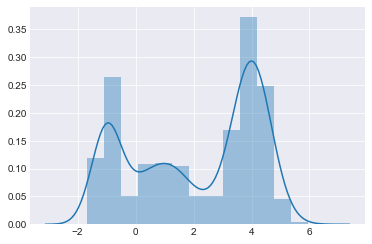

In [2]:
np.random.seed(42)

n = 2500 # Total number of samples
k = 3  # Number of clusters
p_real = np.array([0.2, 0.3, 0.5])  # Probability of choosing each cluster
mus_real = np.array([-1., 1., 4.])  #  Mu of clusters
sigmas_real = np.array([0.2, 0.9, 0.5])  # Sigma of clusters
clusters = np.random.choice(k, size=n, p=p_real)
data = np.random.normal(mus_real[clusters], sigmas_real[clusters], size=n)

print('{} samples in total from {} clusters. data: {}'.format(n, k, data.shape))
sns.distplot(data)
plt.show()

A natural parameterization of the Gaussian mixture model is as the latent variable model

$$
\begin{split}\begin{align*}
\mu_1, \ldots, \mu_k        & \sim \mathcal{N}(0, \sigma^2) \\
\sigma_1, \ldots, \sigma_k  & \sim \text{HalfCauchy}(b) \\
p                           & \sim \text{Dirichlet}(\alpha_1, \ldots. \alpha_k) \\
z \mid p                    & \sim \text{Categorial}(p) \\
x \mid z                    & \sim \mathcal{N}(\mu_z, \sigma_z).
\end{align*}\end{split}
$$

The disadvantage of this is that that sampling the posterior relies on sampling from the categorical variable. And thus we need to create with a lot of different elements in order not to get stuck during sampling.

An alternative is to try to marginalise out the categorical $z$ to sample from a single [mixture distribution](https://en.wikipedia.org/wiki/Mixture_distribution) at the end:

$$
\begin{split}\begin{align*}
\mu_1, \ldots, \mu_k          & \sim \mathcal{N}(0, \sigma^2) \\
\sigma_1, \ldots, \sigma_k    & \sim \text{HalfCauchy}(b) \\
p                             & \sim \text{Dirichlet}(\alpha_1, \ldots. \alpha_k) \\
f(x \mid p) & = \sum_{i = 1}^k p_i \mathcal{N}(x \mid \mu_i, \sigma_z)
\end{align*}\end{split}
$$

with

$$
N(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi} \sigma} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right)
$$

We can write this mixture with the help of [NormalMixture](http://docs.pymc.io/api/distributions/mixture.html#pymc3.distributions.mixture.NormalMixture).

In [3]:
with pm.Model() as model:
    # Prior for cluster probabilities
    # Diriclet([1,1,1]) is like uniform distribution over all clusters
    p = pm.Dirichlet('p', a=np.ones_like(p_real))
    # Prior on cluster means
    mus = pm.Normal('mus', mu=0., sd=10., shape=k)
    # Prior on cluster standard diviations
    sigmas = pm.HalfCauchy('sigmas', beta=10, shape=k)
    observations = pm.NormalMixture('observations', w=p, mu=mus, sd=sigmas, observed=data)

print('Prior cluster assignment, with p: {}'.format(p.tag.test_value))
print('Assigned mu: ', mus.tag.test_value[:10])
print('Assigned sigma: ', sigmas.tag.test_value[:10])

Prior cluster assignment, with p: [0.33333333 0.33333333 0.33333333]
Assigned mu:  [0. 0. 0.]
Assigned sigma:  [10. 10. 10.]


In [4]:
# Run inference
niter = 10000
with model:
    step = pm.NUTS()
    trace = pm.sample(niter, step, random_seed=42, progressbar=True)

100%|██████████| 10500/10500 [01:15<00:00, 139.77it/s]


trace:  (10000, 3)


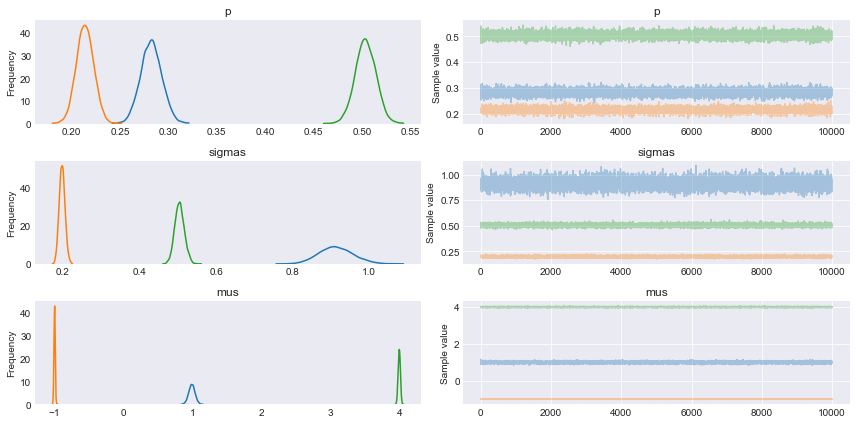

In [5]:
print('trace: ', trace['p'].shape)
pm.traceplot(trace, varnames=['p', 'sigmas', 'mus'])
plt.show()

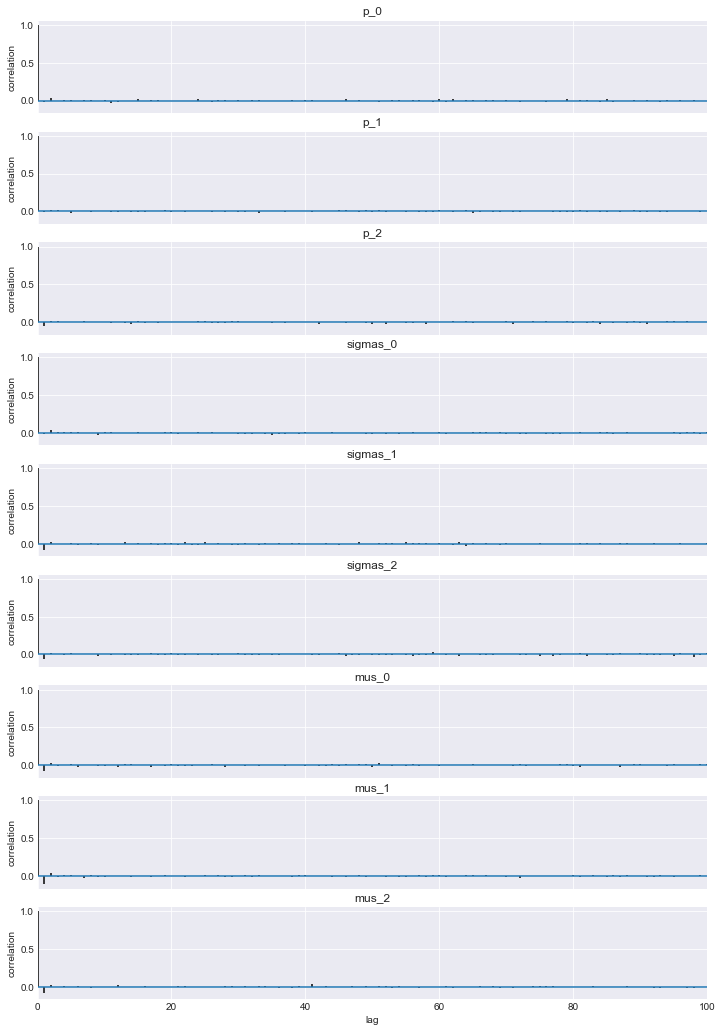

In [6]:
pm.autocorrplot(trace, varnames=['p', 'sigmas', 'mus'])
plt.show()

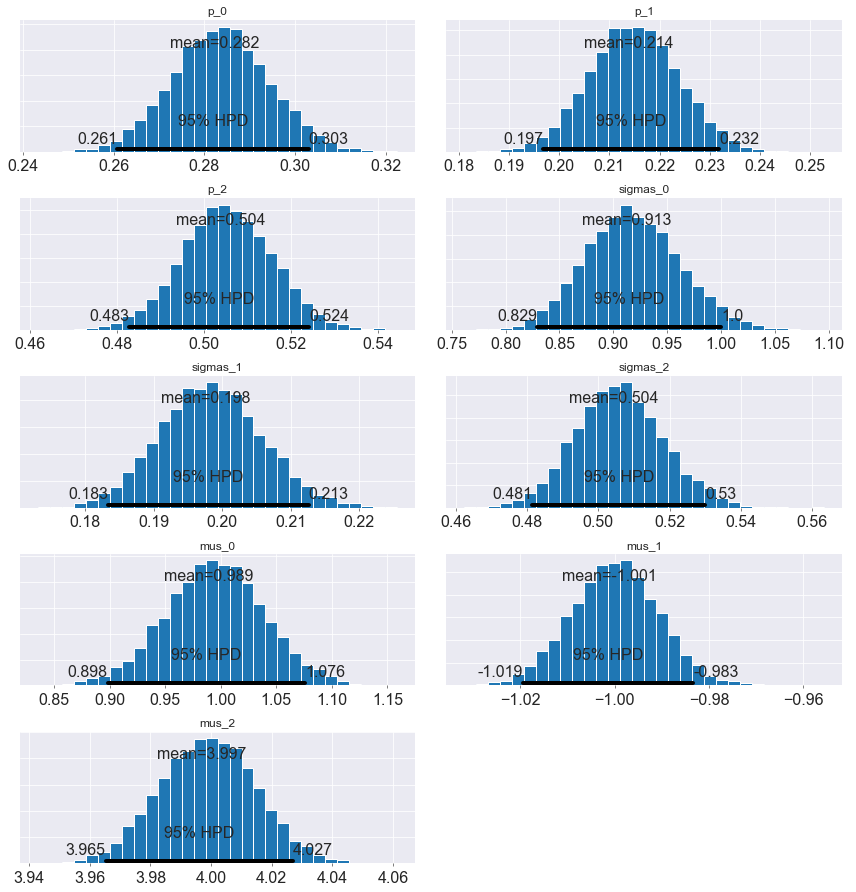

In [7]:
pm.plot_posterior(trace, varnames=['p', 'sigmas', 'mus'])
plt.show()

In [8]:
# Sample from the posterior
with model:
    posterior_trace = pm.sample_ppc(trace, samples=5000, random_seed=42)

100%|██████████| 5000/5000 [00:01<00:00, 2602.78it/s]


Samples from posterior:  (5000,)


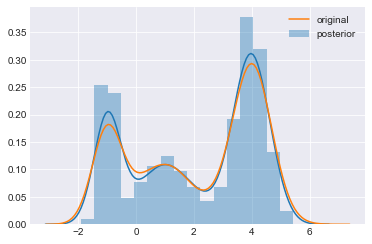

In [9]:
print('Samples from posterior: ', posterior_trace['observations'].shape)
sns.distplot(posterior_trace['observations'], label='posterior')
sns.distplot(data, hist=False, label='original')
plt.show()